Think there are some errors in the implementation. Loss was zero but network predictions have not converged!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def precompute_terms(N: int = 10, delta_t: float = 0.1, g: float = -9.8):
    # velocity and displacement terms mat
    vd_mat = np.stack([
        [i * delta_t for i in range(1, N+1)],
        [1] * N
    ], axis=1)

    accel_mat = np.array([g * (i * delta_t) ** 2 for i in range(1, N+1)])
    accel_mat = np.expand_dims(accel_mat, axis=1)

    F_mat = np.linalg.inv(accel_mat.transpose() @ accel_mat)
    F_mat = accel_mat @ F_mat @ accel_mat.transpose()

    return F_mat, accel_mat

In [3]:
def parabola_loss(preds: np.ndarray, F_mat, accel_mat):
    # preds should have shape (N, 1)
    parabola = accel_mat + F_mat @ (preds - accel_mat)
    return np.sum(np.abs(parabola - preds))

## Further testing required

In [4]:
def generate_parabola():
    # Using parameters from the NASA trebuchet dataset
    delta_t = 0.0333
    N = 20
    t = np.arange(start=0, stop=0.0333*N, step=0.0333)
    g = 9.8
    v0 = np.random.uniform(low=-2, high=-1)
    y0 = np.random.uniform(low=0, high=0.5)
    
    y = 0.5 * 9.8 * t ** 2 + v0 * t + y0
    
    return y

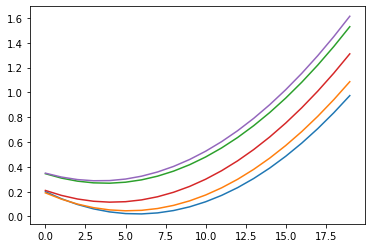

In [5]:
for _ in range(5):
    plt.plot(generate_parabola())

plt.show()

In [6]:
F_mat, accel_mat = precompute_terms(N=20, delta_t=0.0333, g=9.8)

In [7]:
accel_mat

array([[0.01086712],
       [0.04346849],
       [0.0978041 ],
       [0.17387395],
       [0.27167805],
       [0.39121639],
       [0.53248898],
       [0.69549581],
       [0.88023688],
       [1.0867122 ],
       [1.31492176],
       [1.56486557],
       [1.83654362],
       [2.12995591],
       [2.44510245],
       [2.78198323],
       [3.14059826],
       [3.52094753],
       [3.92303104],
       [4.3468488 ]])

In [8]:
for _ in range(5):
    generated_parabola = generate_parabola()
    generated_parabola = np.expand_dims(generated_parabola, axis=-1)
    print(parabola_loss(generated_parabola, F_mat, accel_mat))

1.6035824348170131
2.1391117556553807
2.052469475995691
1.8721528474112732
1.171762745937207


Seems kinda reasonable. I was seeing loss values >100 when a random float tensor was provided as input.

In [9]:
# Example label from dataset
aten = np.array([0.32314324, 0.30089265, 0.28399983, 0.27242175, 0.26611087,
       0.26501596, 0.26908335, 0.2782584 , 0.29248735, 0.31171873,
       0.33590487, 0.36500263, 0.3989738 , 0.437785  , 0.4814075 ,
       0.52981675, 0.5829917 , 0.6409146 , 0.7035703 , 0.77094585],
      dtype=np.float32)
aten = np.expand_dims(aten, axis=-1)

In [10]:
fitted_parabola = accel_mat + F_mat @ (aten - accel_mat)

In [11]:
fitted_parabola.shape

(20, 1)

In [12]:
fitted_parabola

array([[0.00213015],
       [0.0085206 ],
       [0.01917135],
       [0.0340824 ],
       [0.05325375],
       [0.0766854 ],
       [0.10437735],
       [0.1363296 ],
       [0.17254215],
       [0.213015  ],
       [0.25774816],
       [0.30674161],
       [0.35999536],
       [0.41750941],
       [0.47928376],
       [0.54531841],
       [0.61561336],
       [0.69016861],
       [0.76898417],
       [0.85206002]])

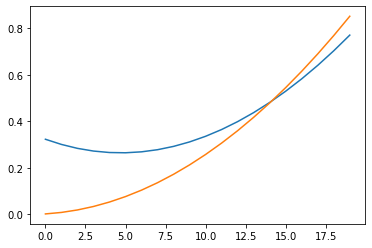

In [13]:
plt.plot(aten)
plt.plot(fitted_parabola)
plt.show()

Seems to indicate that the gravity term used wasn't steep enough!

In [14]:
# Doubled g
F_mat, accel_mat = precompute_terms(N=20, delta_t=0.0333, g=9.8 * 2)
fitted_parabola = accel_mat + F_mat @ (aten - accel_mat)

In [15]:
# accel_mat # verified to be doubled correctly

In [16]:
fitted_parabola

array([[0.00213015],
       [0.0085206 ],
       [0.01917135],
       [0.0340824 ],
       [0.05325375],
       [0.0766854 ],
       [0.10437735],
       [0.1363296 ],
       [0.17254215],
       [0.213015  ],
       [0.25774816],
       [0.30674161],
       [0.35999536],
       [0.41750941],
       [0.47928376],
       [0.54531841],
       [0.61561336],
       [0.69016861],
       [0.76898417],
       [0.85206002]])

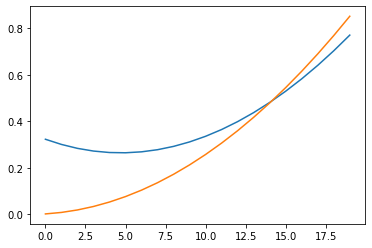

In [17]:
plt.plot(aten)
plt.plot(fitted_parabola)
plt.show()

Fitted parabola is exactly the same. Something is wrong here.

## A more thorough experiment

In [18]:
F_mat_before, accel_mat_before = precompute_terms(N=20, delta_t=0.0333, g=9.8)
F_mat_after, accel_mat_after = precompute_terms(N=20, delta_t=0.0333, g=2*9.8)

In [19]:
np.concatenate([aten - accel_mat_before, aten - accel_mat_after], axis=1)

array([[ 3.12276122e-01,  3.01409000e-01],
       [ 2.57424163e-01,  2.13955675e-01],
       [ 1.86195732e-01,  8.83916345e-02],
       [ 9.85477954e-02, -7.53261566e-02],
       [-5.56718274e-03, -2.77245233e-01],
       [-1.26200432e-01, -5.17416824e-01],
       [-2.63405627e-01, -7.95894605e-01],
       [-4.17237395e-01, -1.11273320e+00],
       [-5.87749529e-01, -1.46798641e+00],
       [-7.74993468e-01, -1.86170567e+00],
       [-9.79016896e-01, -2.29393866e+00],
       [-1.19986294e+00, -2.76472850e+00],
       [-1.43756983e+00, -3.27411344e+00],
       [-1.69217091e+00, -3.82212682e+00],
       [-1.96369496e+00, -4.40879741e+00],
       [-2.25216649e+00, -5.03414972e+00],
       [-2.55760654e+00, -5.69820480e+00],
       [-2.88003291e+00, -6.40098044e+00],
       [-3.21946074e+00, -7.14249178e+00],
       [-3.57590295e+00, -7.92275175e+00]])

Seems to be acting reasonably so far. Doubled gravity should have larger difference between `aten` and `accel_mat`.

In [20]:
fitted_parabola_before = accel_mat_before + F_mat_before @ (aten - accel_mat_before)
fitted_parabola_after = accel_mat_after + F_mat_after @ (aten - accel_mat_after)

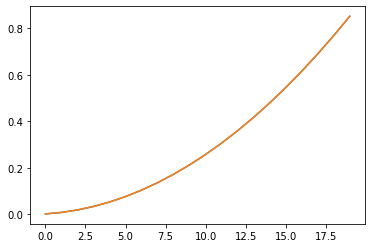

In [21]:
plt.plot(fitted_parabola_before)
plt.plot(fitted_parabola_after)
plt.show()

In [22]:
F_mat_before[5, :]

array([4.98155441e-05, 1.99262176e-04, 4.48339897e-04, 7.97048706e-04,
       1.24538860e-03, 1.79335959e-03, 2.44096166e-03, 3.18819482e-03,
       4.03505907e-03, 4.98155441e-03, 6.02768084e-03, 7.17343835e-03,
       8.41882695e-03, 9.76384665e-03, 1.12084974e-02, 1.27527793e-02,
       1.43966922e-02, 1.61402363e-02, 1.79834114e-02, 1.99262176e-02])

In [23]:
F_mat_after[5, :]

array([4.98155441e-05, 1.99262176e-04, 4.48339897e-04, 7.97048706e-04,
       1.24538860e-03, 1.79335959e-03, 2.44096166e-03, 3.18819482e-03,
       4.03505907e-03, 4.98155441e-03, 6.02768084e-03, 7.17343835e-03,
       8.41882695e-03, 9.76384665e-03, 1.12084974e-02, 1.27527793e-02,
       1.43966922e-02, 1.61402363e-02, 1.79834114e-02, 1.99262176e-02])

In [24]:
np.sum(F_mat_after - F_mat_before)

0.0

F_mat is exactly the same before and after! Therefore something is wrong in the formulation.

Pouring over the math again, I found that some of the terms are wrong. In the Colab notebook, I used `A_mat` for big A and `accel_mat` for small a in the equation. Goofed the variable change when I replaced `A_mat` with `vd_mat`.

Should be like this:

In [25]:
def precompute_terms(N: int = 10, delta_t: float = 0.1, g: float = -9.8):
    # velocity and displacement terms mat
    vd_mat = np.stack([
        [i * delta_t for i in range(1, N+1)],
        [1] * N
    ], axis=1)

    accel_mat = np.array([g * (i * delta_t) ** 2 for i in range(1, N+1)])
    accel_mat = np.expand_dims(accel_mat, axis=1)

    F_mat = np.linalg.inv(vd_mat.transpose() @ vd_mat)
    F_mat = vd_mat @ F_mat @ vd_mat.transpose()

    return F_mat, accel_mat

## Repeat experiment

In [26]:
F_mat_before, accel_mat_before = precompute_terms(N=20, delta_t=0.0333, g=9.8)
F_mat_after, accel_mat_after = precompute_terms(N=20, delta_t=0.0333, g=2*9.8)

In [27]:
fitted_parabola_before = accel_mat_before + F_mat_before @ (aten - accel_mat_before)
fitted_parabola_after = accel_mat_after + F_mat_after @ (aten - accel_mat_after)

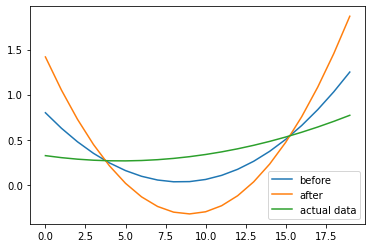

In [29]:
plt.plot(fitted_parabola_before, label="before")
plt.plot(fitted_parabola_after, label="after")
plt.plot(aten, label="actual data")
plt.legend()
plt.show()

Alrighty. This behaves as intended. Higher gravity causes a steeper parabola.

## Tweaking g

In [40]:
F_mat, accel_mat = precompute_terms(N=20, delta_t=0.0333, g=9.8 / 4)
fitted_parabola = accel_mat + F_mat @ (aten - accel_mat)

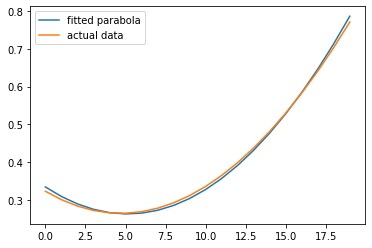

In [41]:
plt.plot(fitted_parabola, label="fitted parabola")
plt.plot(aten, label="actual data")
plt.legend()
plt.show()

Tried a range of divisors from 2 to 8. 4 fit the best. Why? Hunch is it's coz of the coordinate scaling.

In [42]:
parabola_loss(fitted_parabola, F_mat, accel_mat)

1.5543122344752192e-15

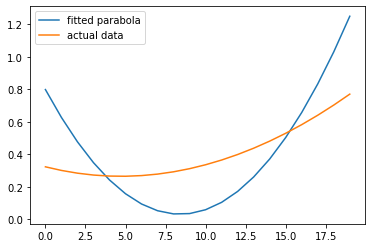

In [45]:
F_mat, accel_mat = precompute_terms(N=20, delta_t=0.0333, g=9.8)
fitted_parabola = accel_mat + F_mat @ (aten - accel_mat)

plt.plot(fitted_parabola, label="fitted parabola")
plt.plot(aten, label="actual data")
plt.legend()
plt.show()

In [46]:
parabola_loss(fitted_parabola, F_mat, accel_mat)

8.631984016460592e-15

Huh wow this parabola somehow scores pretty low compared to the actual data. Oh right this loss measures for how well does it approximate a parabola.